### Importing Libraries

In [1]:
import warnings
import itertools

import pandas as pd
import numpy as np

import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf

import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('bmh')

In [2]:
#load all libraries
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics
from xgboost import XGBRegressor
from sklearn.preprocessing import OneHotEncoder


### Dataset

In [3]:
features = pd.read_csv("./data/features.csv")
train = pd.read_csv("./data/train.csv")
test = pd.read_csv("./data/test.csv")
store = pd.read_csv("./data/stores.csv")

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [5]:
test.head()

,Store,Dept,Date,IsHoliday
0,1,1,2012-11-02,False
1,1,1,2012-11-09,False
2,1,1,2012-11-16,False
3,1,1,2012-11-23,True
4,1,1,2012-11-30,False


In [6]:
store.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [7]:
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Store   45 non-null     int64 
 1   Type    45 non-null     object
 2   Size    45 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 1.2+ KB


In [8]:
# Load store dataset and join with above data
# Load train dataset
df = pd.read_csv("./data/train.csv")
# Load features dataset and join it with train data
features_df = pd.read_csv("./data/features.csv")
df = pd.merge(df, features_df.drop(['IsHoliday'], axis = 1), how = 'left', on = ['Store', 'Date'])
# Load store dataset and join with above data
stores_df = pd.read_csv("./data/stores.csv")
df = pd.merge(df, stores_df, how = 'left', on = ['Store'])
df.shape

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(344181, 16)

In [9]:
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
1,1,1,2010-02-12,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,A,151315
2,1,1,2010-02-19,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315
3,1,1,2010-02-26,19403.54,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,A,151315
4,1,1,2010-03-05,21827.90,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,A,151315


In [10]:
# Explore variables, their data types, and total non-null values
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 344181 entries, 0 to 344180
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         344181 non-null  int64  
 1   Dept          344181 non-null  int64  
 2   Date          344181 non-null  object 
 3   Weekly_Sales  344181 non-null  float64
 4   IsHoliday     344181 non-null  object 
 5   Temperature   344181 non-null  float64
 6   Fuel_Price    344181 non-null  float64
 7   MarkDown1     123080 non-null  float64
 8   MarkDown2     95234 non-null   float64
 9   MarkDown3     112865 non-null  float64
 10  MarkDown4     117799 non-null  float64
 11  MarkDown5     123333 non-null  float64
 12  CPI           344181 non-null  float64
 13  Unemployment  344181 non-null  float64
 14  Type          344181 non-null  object 
 15  Size          344181 non-null  int64  
dtypes: float64(10), int64(3), object(3)
memory usage: 44.6+ MB


In [11]:
# summary statistics of the dataset
df[['Weekly_Sales', 'Temperature', 'CPI', 'Size']].describe()


,Weekly_Sales,Temperature,CPI,Size
count,344181.000000,344181.000000,344181.000000,344181.000000
mean,16599.339060,59.743511,170.645829,144216.332854
std,23413.660971,18.464370,39.628496,57312.427975
min,-4988.940000,-2.060000,126.064000,34875.000000
25%,2454.590000,46.350000,132.364839,112238.000000
50%,8026.180000,61.580000,142.115810,151315.000000
75%,20929.090000,73.880000,213.478550,203742.000000
max,693099.360000,100.140000,227.232807,219622.000000


In [12]:
# Explore the range of dates for which weekly sales data is available
print('Min Date in Data is - {}'.format(df['Date'].min()))
print('Max Date in Data is - {}'.format(df['Date'].max()))


Min Date in Data is - 2010-02-05
Max Date in Data is - 2012-10-26


In [13]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 275380 entries, 0 to 275379
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         275380 non-null  int64  
 1   Dept          275380 non-null  int64  
 2   Date          275380 non-null  object 
 3   Weekly_Sales  275379 non-null  float64
 4   IsHoliday     275379 non-null  object 
dtypes: float64(1), int64(2), object(2)
memory usage: 10.5+ MB


  Type  Store
0    A     19
1    B     16
2    C      1


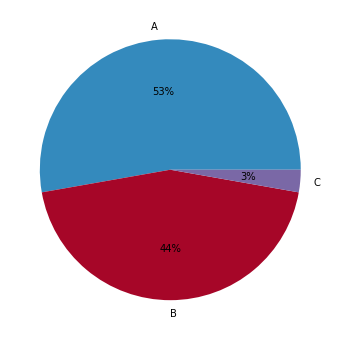

In [14]:
temp = pd.DataFrame(df.groupby('Type')['Store'].nunique()).reset_index()
print(temp)
plt.figure(figsize = (12,6))
plt.pie(temp['Store'], labels = temp['Type'], autopct = '%.0f%%')
plt.show()


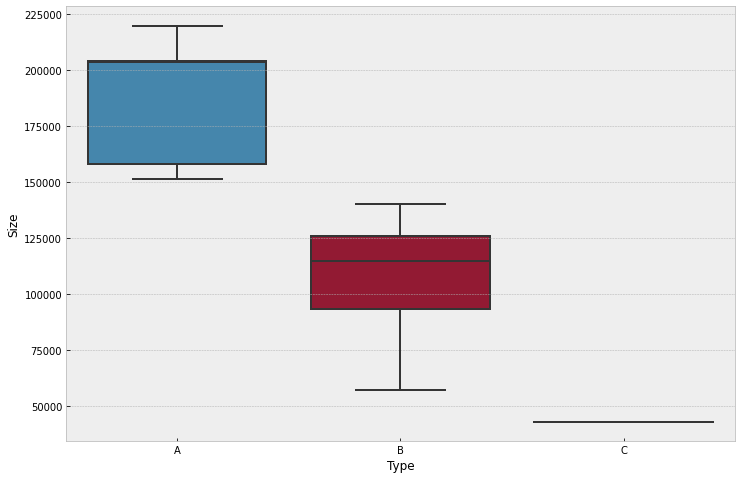

In [15]:
# Explore the size distribution of stores for each store type. 
# As shown below, store type A are the largest ones, store type B are smaller than A, and store type C are the smallest ones.
# size distribution of stores for each store type
plt.figure(figsize = (12,8))
sns.boxplot(x = 'Type', y ='Size', data = df, showfliers = False)



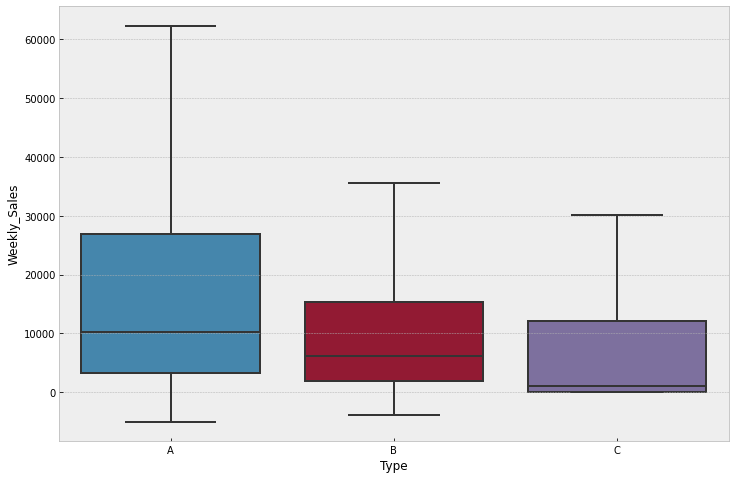

In [16]:
# Distribution of weekly sales based on store type
plt.figure(figsize = (12,8))
sns.boxplot(x = 'Type', y ='Weekly_Sales', data = df, showfliers = False)


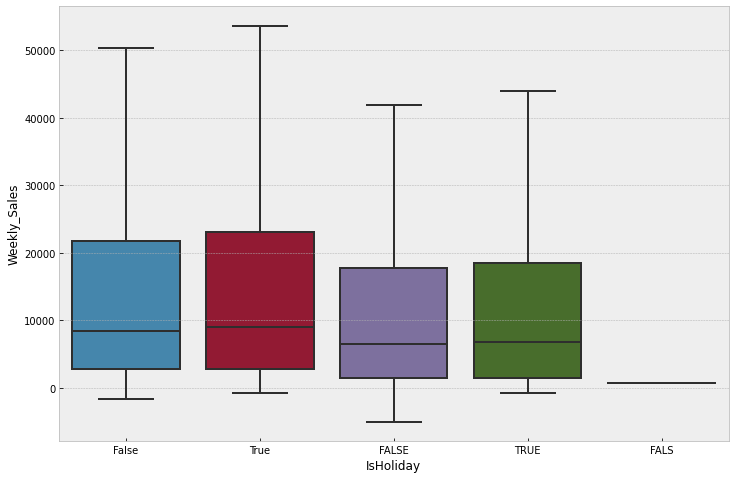

In [17]:
# impact of holidays on weekly sales
plt.figure(figsize = (12,8))
sns.boxplot(x = 'IsHoliday', y ='Weekly_Sales', data = df, showfliers = False)


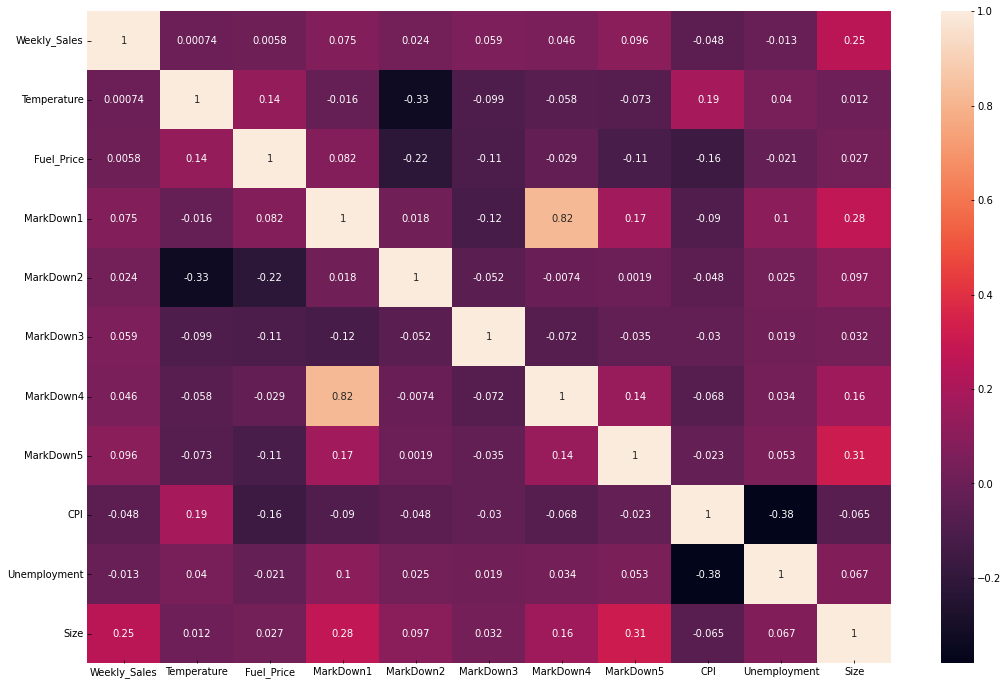

In [18]:
feature_cols = ['Weekly_Sales', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4',
       'MarkDown5', 'CPI', 'Unemployment', 'Size']
plt.figure(figsize = (18,12))
sns.heatmap(df[feature_cols].corr(), annot = True)


In [19]:
features = pd.read_csv("./data/features.csv")
train = pd.read_csv("./data/train.csv")
test = pd.read_csv("./data/test.csv")
store = pd.read_csv("./data/stores.csv")

In [20]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115064 entries, 0 to 115063
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Store      115064 non-null  int64 
 1   Dept       115064 non-null  int64 
 2   Date       115064 non-null  object
 3   IsHoliday  115064 non-null  bool  
dtypes: bool(1), int64(2), object(1)
memory usage: 2.7+ MB


In [21]:
# changing datatype to datetime format
train['Date']=pd.to_datetime(train['Date'])
test['Date']=pd.to_datetime(test['Date'])

In [22]:
# Data Exploratory
train['Month']=train['Date'].dt.month
train['Year']=train['Date'].dt.year
train['Dayofweek']=train['Date'].dt.dayofweek

In [23]:
train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Month,Year,Dayofweek
0,1,1,2010-02-05,24924.50,False,2,2010,4
1,1,1,2010-02-12,46039.49,True,2,2010,4
2,1,1,2010-02-19,41595.55,False,2,2010,4
3,1,1,2010-02-26,19403.54,False,2,2010,4
4,1,1,2010-03-05,21827.90,False,3,2010,4


In [24]:
# data Exploratory
test['Month']=test['Date'].dt.month
test['Year']=test['Date'].dt.year
test['Dayofweek']=test['Date'].dt.dayofweek

In [25]:
test.head()

,Store,Dept,Date,IsHoliday,Month,Year,Dayofweek
0,1,1,2012-11-02,False,11,2012,4
1,1,1,2012-11-09,False,11,2012,4
2,1,1,2012-11-16,False,11,2012,4
3,1,1,2012-11-23,True,11,2012,4
4,1,1,2012-11-30,False,11,2012,4


In [26]:
# set the dates as the index of the dataframe, so that it can be treated as a time-series dataframe
train.set_index('Date',inplace=True)
test.set_index('Date',inplace=True)

In [27]:
# extract out the time-series
sales=train.groupby('Date')['Weekly_Sales'].sum()
sales.head()
# print (sales)

Date
2010-02-05    49750740.50
2010-02-12    48336677.63
2010-02-19    48276993.78
2010-02-26    43968571.13
2010-03-05    46871470.30
Name: Weekly_Sales, dtype: float64

Text(0, 0.5, 'Weekly_Sales')

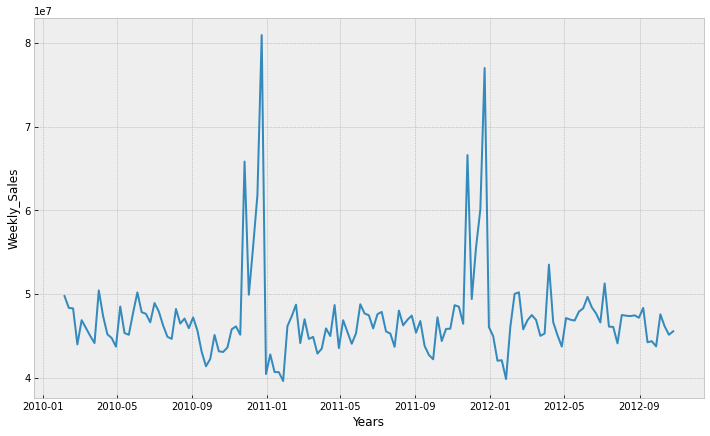

In [28]:
plt.figure(figsize=(12, 7))
plt.plot(sales)
plt.xlabel('Years')
plt.ylabel('Weekly_Sales')

In [29]:
sales_mean=sales.rolling(window=12).mean().round(4)
sales_std=sales.rolling(window=12).std().round(4)
print(sales_mean,sales_std)

Date
2010-02-05             NaN
2010-02-12             NaN
2010-02-19             NaN
2010-02-26             NaN
2010-03-05             NaN
                  ...     
2012-09-28    4.614606e+07
2012-10-05    4.626830e+07
2012-10-12    4.627405e+07
2012-10-19    4.635949e+07
2012-10-26    4.619767e+07
Name: Weekly_Sales, Length: 143, dtype: float64 Date
2010-02-05             NaN
2010-02-12             NaN
2010-02-19             NaN
2010-02-26             NaN
2010-03-05             NaN
                  ...     
2012-09-28    1.630511e+06
2012-10-05    1.680931e+06
2012-10-12    1.680270e+06
2012-10-19    1.582753e+06
2012-10-26    1.556161e+06
Name: Weekly_Sales, Length: 143, dtype: float64


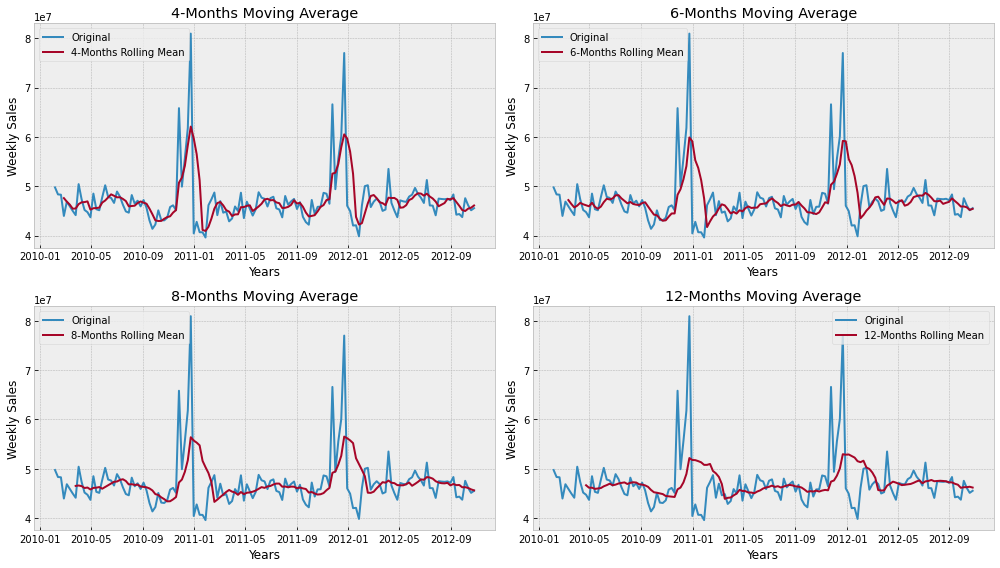

In [30]:
fig, axes = plt.subplots(2, 2)
fig.set_figwidth(14)
fig.set_figheight(8)

axes[0][0].plot(sales.index, sales, label='Original')
axes[0][0].plot(sales.index, sales.rolling(window=4).mean(), label='4-Months Rolling Mean')
axes[0][0].set_xlabel("Years")
axes[0][0].set_ylabel("Weekly Sales")
axes[0][0].set_title("4-Months Moving Average")
axes[0][0].legend(loc='best')

axes[0][1].plot(sales.index, sales, label='Original')
axes[0][1].plot(sales.index, sales.rolling(window=6).mean(), label='6-Months Rolling Mean')
axes[0][1].set_xlabel("Years")
axes[0][1].set_ylabel("Weekly Sales")
axes[0][1].set_title("6-Months Moving Average")
axes[0][1].legend(loc='best')

axes[1][0].plot(sales.index, sales, label='Original')
axes[1][0].plot(sales.index, sales.rolling(window=8).mean(), label='8-Months Rolling Mean')
axes[1][0].set_xlabel("Years")
axes[1][0].set_ylabel("Weekly Sales")
axes[1][0].set_title("8-Months Moving Average")
axes[1][0].legend(loc='best')

axes[1][1].plot(sales.index, sales, label='Original')
axes[1][1].plot(sales.index, sales.rolling(window=12).mean(), label='12-Months Rolling Mean')
axes[1][1].set_xlabel("Years")
axes[1][1].set_ylabel("Weekly Sales")
axes[1][1].set_title("12-Months Moving Average")
axes[1][1].legend(loc='best')

plt.tight_layout()
plt.show()

##### Step 1.2: Seasonality – Time Series Decomposition
The first thing to do is to see how weekly sales vary on a month basis. We will plot a stacked annual plot to observe seasonality in our data.

In [31]:
train.head()

,Store,Dept,Weekly_Sales,IsHoliday,Month,Year,Dayofweek
Date,,,,,,,
2010-02-05,1,1,24924.50,False,2,2010,4
2010-02-12,1,1,46039.49,True,2,2010,4
2010-02-19,1,1,41595.55,False,2,2010,4
2010-02-26,1,1,19403.54,False,2,2010,4
2010-03-05,1,1,21827.90,False,3,2010,4


In [32]:
monthly_sales = pd.pivot_table(train, values = "Weekly_Sales", columns = "Year", index = "Month")
monthly_sales = monthly_sales.reindex(index = [1,2,3,4,5,6,7,8,9,10,11,12])
monthly_sales

Year,2010,2011,2012
Month,,,
1,NaN,13997.773991,14252.698030
2,16076.778701,15870.141203,16077.647710
3,15432.626612,15182.972005,15589.875454
4,15745.551340,15361.895495,15890.394983
5,15996.481695,15367.864481,15967.389566
6,16486.250953,16188.124643,16309.247563
7,15972.812718,15724.738313,15893.325343
8,16171.689295,16030.542478,16002.348874
9,15120.086691,14961.570247,15239.205709


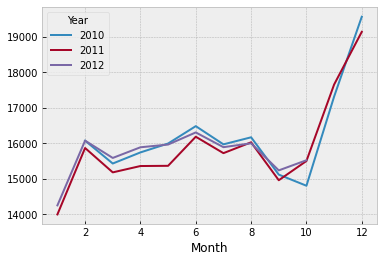

In [33]:
monthly_sales.plot()

##### Important Inferences
June,November and December are the peak months for weekly sales and the variance and the mean value in June,November and December are also much higher than any of the other months.

We can see a seasonal cycle of 12 months where the mean value of each month starts with a decreasing trend in the beginning of the year and increases towards the end of the year. We can see a seasonal effect with a cycle of 12 months.

#####  Step 1.3: Irregular Remainder – Time Series Decomposition

In [34]:
decomposition = sm.tsa.seasonal_decompose(sales, extrapolate_trend=8)

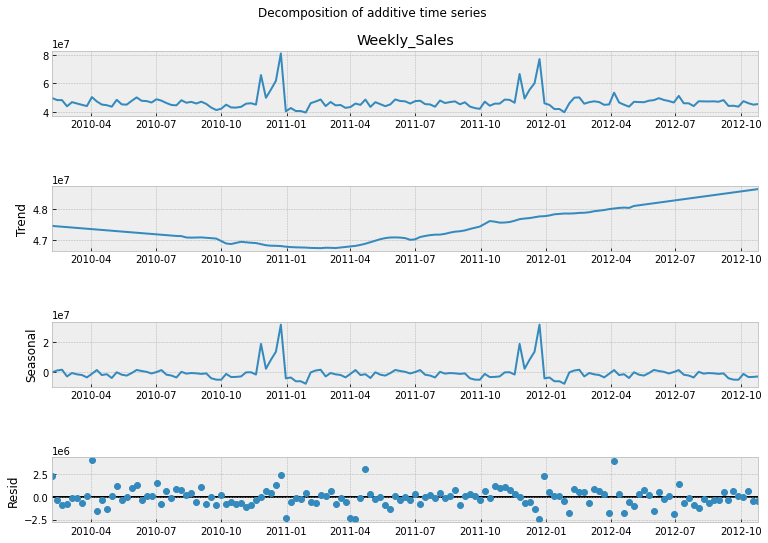

In [35]:
fig = decomposition.plot()
fig.set_figwidth(12)
fig.set_figheight(8)
fig.suptitle('Decomposition of additive time series')
plt.show()

In [36]:
decomp_output = pd.DataFrame(pd.concat([decomposition.observed, decomposition.trend, decomposition.seasonal, decomposition.resid], axis=1))

In [37]:
decomp_output.columns = ['observed', 'Trend', 'Seasonal', 'Irregular']

In [38]:
decomp_output['TSI'] = decomp_output.Trend*decomp_output.Seasonal*decomp_output.Irregular

In [39]:
decomp_output

,observed,Trend,Seasonal,Irregular,TSI
Date,,,,,
2010-02-05,49750740.50,4.746247e+07,2.717348e+02,2.288001e+06,2.950882e+16
2010-02-12,48336677.63,4.744942e+07,1.234856e+06,-3.475975e+05,-2.036685e+19
2010-02-19,48276993.78,4.743637e+07,1.737900e+06,-8.972774e+05,-7.397127e+19
2010-02-26,43968571.13,4.742332e+07,-2.705045e+06,-7.497064e+05,9.617400e+19
2010-03-05,46871470.30,4.741027e+07,-4.231219e+05,-1.156816e+05,2.320610e+18
...,...,...,...,...,...
2012-09-28,43734899.40,4.857360e+07,-4.910067e+06,7.136779e+04,-1.702119e+19
2012-10-05,47566639.31,4.859558e+07,-1.016989e+06,-1.195188e+04,5.906763e+17
2012-10-12,46128514.25,4.861756e+07,-3.124785e+06,6.357362e+05,-9.658067e+19


###  Timeseries Forecasting using FBProphet

In [40]:
!pip install pystan~=2.14
!pip install fbprophet
# from fbprophet import Prophet 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 MB 11.5 MB/s eta 0:00:00
  Attempting uninstall: pystan
    Found existing installation: pystan 3.3.0
    Uninstalling pystan-3.3.0:
      Successfully uninstalled pystan-3.3.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.0/64.0 KB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fbprophet: filename=fbprophet-0.7.1-py3-none-any.whl size=9535636 sha256=6b1b49b2e1f10c6cf2c6ca216b4cabfe862aaaee23487668a233af93a158b480
  Stored in directory: /root/.cache/pip/wheels/d0/d2/ae/c579b7fd160999d35908f3cb8ebcad7ef64ecaca7b78e4c3c8
Successfully built fbprophet
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 1.1.0
    Uninstalling cmdstanpy-1.1.0:
      Successfully uninstalled cmdsta

In [41]:
from fbprophet import Prophet 

In [42]:
train=train.groupby('Date')[['Weekly_Sales']].sum()

In [43]:
train['ds'] = train.index

In [44]:
train.head()

,Weekly_Sales,ds
Date,,
2010-02-05,49750740.50,2010-02-05
2010-02-12,48336677.63,2010-02-12
2010-02-19,48276993.78,2010-02-19
2010-02-26,43968571.13,2010-02-26
2010-03-05,46871470.30,2010-03-05


In [45]:
train = train[['ds', 'Weekly_Sales']].rename(columns={'ds': 'ds', 'Weekly_Sales': 'y'})

In [46]:
sales_model = Prophet(seasonality_mode='additive',interval_width=0.95)
sales_model.fit(train)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [47]:
sales_forecast = sales_model.make_future_dataframe(periods=36, freq='MS')
sales_forecast = sales_model.predict(sales_forecast)

In [48]:
sales_forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2010-02-05,4.713438e+07,4.066449e+07,5.458343e+07,4.713438e+07,4.713438e+07,7.064822e+05,7.064822e+05,7.064822e+05,7.064822e+05,7.064822e+05,7.064822e+05,0.0,0.0,0.0,4.784086e+07
1,2010-02-12,4.713143e+07,4.141171e+07,5.497963e+07,4.713143e+07,4.713143e+07,1.412471e+06,1.412471e+06,1.412471e+06,1.412471e+06,1.412471e+06,1.412471e+06,0.0,0.0,0.0,4.854390e+07
2,2010-02-19,4.712847e+07,4.038625e+07,5.392609e+07,4.712847e+07,4.712847e+07,3.251732e+04,3.251732e+04,3.251732e+04,3.251732e+04,3.251732e+04,3.251732e+04,0.0,0.0,0.0,4.716099e+07
3,2010-02-26,4.712552e+07,3.959861e+07,5.294753e+07,4.712552e+07,4.712552e+07,-1.179955e+06,-1.179955e+06,-1.179955e+06,-1.179955e+06,-1.179955e+06,-1.179955e+06,0.0,0.0,0.0,4.594556e+07
4,2010-03-05,4.712256e+07,3.907471e+07,5.193644e+07,4.712256e+07,4.712256e+07,-1.452741e+06,-1.452741e+06,-1.452741e+06,-1.452741e+06,-1.452741e+06,-1.452741e+06,0.0,0.0,0.0,4.566982e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174,2015-06-01,4.999598e+07,4.342590e+07,5.718534e+07,4.933918e+07,5.070353e+07,2.140687e+05,2.140687e+05,2.140687e+05,2.140687e+05,2.140687e+05,2.140687e+05,0.0,0.0,0.0,5.021005e+07
175,2015-07-01,5.005219e+07,4.369664e+07,5.741824e+07,4.937332e+07,5.080047e+07,5.058478e+05,5.058478e+05,5.058478e+05,5.058478e+05,5.058478e+05,5.058478e+05,0.0,0.0,0.0,5.055804e+07
176,2015-08-01,5.011027e+07,4.179907e+07,5.597581e+07,4.940638e+07,5.089870e+07,-1.429160e+06,-1.429160e+06,-1.429160e+06,-1.429160e+06,-1.429160e+06,-1.429160e+06,0.0,0.0,0.0,4.868111e+07
177,2015-09-01,5.016836e+07,4.326192e+07,5.709479e+07,4.943049e+07,5.099490e+07,-2.296261e+04,-2.296261e+04,-2.296261e+04,-2.296261e+04,-2.296261e+04,-2.296261e+04,0.0,0.0,0.0,5.014539e+07


<Figure size 1296x432 with 0 Axes>

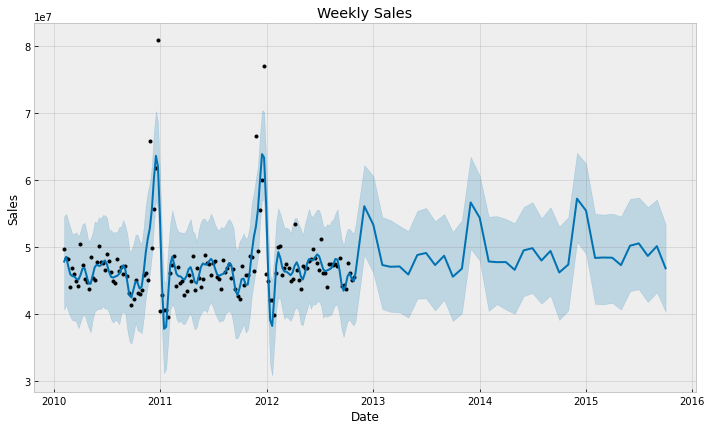

In [49]:
plt.figure(figsize=(18, 6))
sales_model.plot(sales_forecast, xlabel = 'Date', ylabel = 'Sales')
plt.title('Weekly Sales');

##### Trends and Patterns
Now, we can use the Prophet Models to inspect different trends of these two categories in the data.

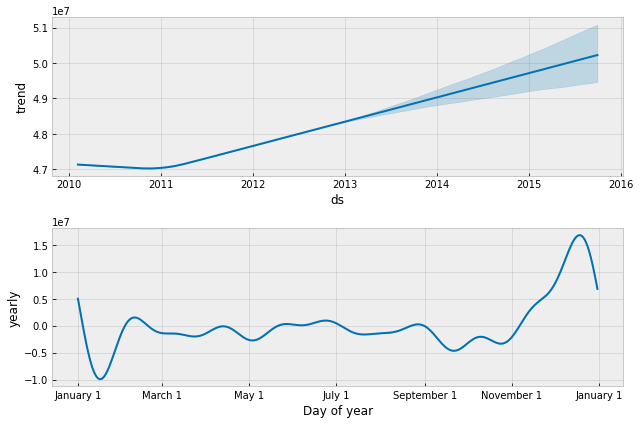

In [50]:
sales_model.plot_components(sales_forecast);

##### Good to see that the weekly sales have been linearly increasing over time

The worst months for weekly sales are January,October. The best months for weekly sales are June,November and December.

## Stationary Data for ARIMA models

In [51]:
# Perform Dickey-Fuller test:
from statsmodels.tsa.stattools import adfuller
adfuller(sales)

(-5.908297957186334,
 2.675979158986027e-07,
 4,
 138,
 {'1%': -3.47864788917503,
  '5%': -2.882721765644168,
  '10%': -2.578065326612056},
 4314.46014989216)

In [52]:
# Perform Dickey-Fuller test:
from statsmodels.tsa.stattools import adfuller
print('Results of Dickey-Fuller Test:')
dftest = adfuller(sales)
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                -5.908298e+00
p-value                        2.675979e-07
#lags Used                     4.000000e+00
Number of Observations Used    1.380000e+02
Critical Value (1%)           -3.478648e+00
Critical Value (5%)           -2.882722e+00
Critical Value (10%)          -2.578065e+00
dtype: float64


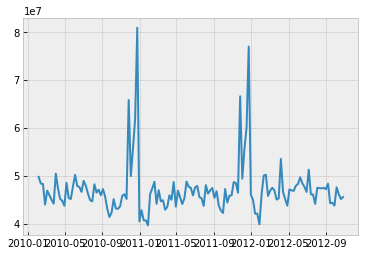

In [53]:
plt.plot(sales)

In [54]:
sales_log = np.log10(sales)

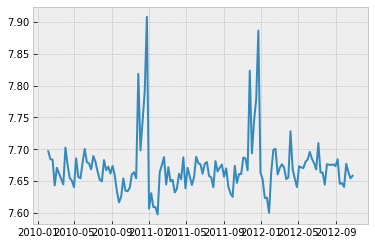

In [55]:
plt.plot(sales_log)

In [56]:
# Perform Dickey-Fuller test:
from statsmodels.tsa.stattools import adfuller
print('Results of Dickey-Fuller Test:')
dftest = adfuller(sales_log)
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                -6.332826e+00
p-value                        2.878283e-08
#lags Used                     4.000000e+00
Number of Observations Used    1.380000e+02
Critical Value (1%)           -3.478648e+00
Critical Value (5%)           -2.882722e+00
Critical Value (10%)          -2.578065e+00
dtype: float64


In [57]:
sales.diff(1).head()

Date
2010-02-05           NaN
2010-02-12   -1414062.87
2010-02-19     -59683.85
2010-02-26   -4308422.65
2010-03-05    2902899.17
Name: Weekly_Sales, dtype: float64

In [58]:
sales_diff1 = sales.diff(1)
sales_diff1.dropna(inplace=True)

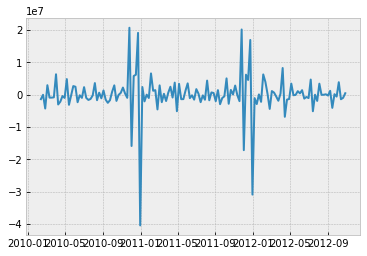

In [59]:
plt.plot(sales_diff1)

In [60]:
# Perform Dickey-Fuller test:
from statsmodels.tsa.stattools import adfuller
print('Results of Dickey-Fuller Test:')
dftest = adfuller(sales_diff1)
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                -6.699469e+00
p-value                        3.922579e-09
#lags Used                     7.000000e+00
Number of Observations Used    1.340000e+02
Critical Value (1%)           -3.480119e+00
Critical Value (5%)           -2.883362e+00
Critical Value (10%)          -2.578407e+00
dtype: float64


In [61]:
sales_log_diff1 = sales_log.diff(1)
sales_log_diff1.dropna(inplace=True)

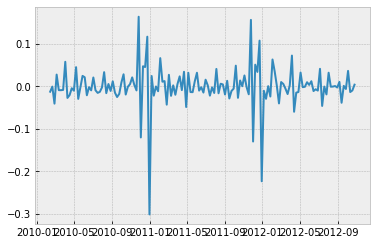

In [62]:
plt.plot(sales_log_diff1)

In [63]:
# Perform Dickey-Fuller test:
from statsmodels.tsa.stattools import adfuller
print('Results of Dickey-Fuller Test:')
dftest = adfuller(sales_log_diff1)
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                -6.747059e+00
p-value                        3.016343e-09
#lags Used                     7.000000e+00
Number of Observations Used    1.340000e+02
Critical Value (1%)           -3.480119e+00
Critical Value (5%)           -2.883362e+00
Critical Value (10%)          -2.578407e+00
dtype: float64


In [64]:
sales_log_diff2 = sales_log.diff(2)
sales_log_diff2.dropna(inplace=True)

In [65]:
from statsmodels.tsa.stattools import adfuller
print('Results of Dickey-Fuller Test:')
dftest = adfuller(sales_log_diff2)
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                -7.558182e+00
p-value                        3.059679e-11
#lags Used                     4.000000e+00
Number of Observations Used    1.360000e+02
Critical Value (1%)           -3.479372e+00
Critical Value (5%)           -2.883037e+00
Critical Value (10%)          -2.578234e+00
dtype: float64


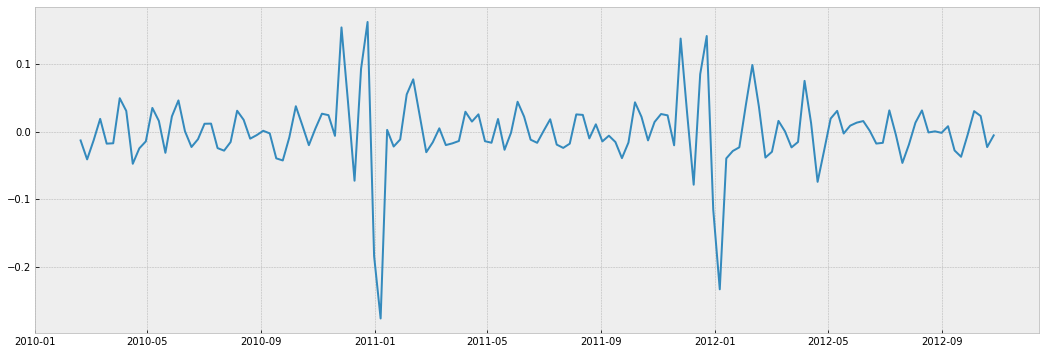

In [66]:
plt.figure(figsize=(18, 6))
plt.plot(sales_log_diff2)

The following are some of our key observations from this analysis: 
1) Trend: 12-months moving average looks quite similar to a straight line hence we could have easily used linear regression to estimate the trend in this data. 2) Seasonality: As discussed, seasonal plot displays a fairly consistent month-on-month pattern. The monthly seasonal components are average values for a month after removal of trend. Trend is removed from the time series using the following formula:

      Seasonalityt×Remaindert=YtTrendt

3) Irregular Remainder (random): is the residual left in the series after removal of trend and seasonal components. Remainder is calculated using the following formula:

       Remaindert=YtTrendt×Seasonalityt
The expectations from remainder component is that it should look like a white noise i.e. displays no pattern at all. However, for our series residual display some pattern with high variation on the edges of data i.e. near the beginning (2011-2012) and the end (2011-2012) of the series.

### ARIMA Modeling

Step 2: Difference data to make data stationary on mean (remove trend)

Clearly the tractor sales has an upward trend for weekly sales and there is also a seasonal component that we have already analyzed.

The next thing to do is to make the series stationary by removing the upward trend through 1st order differencing of the series using the following formula:

1st Differencing (d=1) | Y′t=Yt−Yt−1

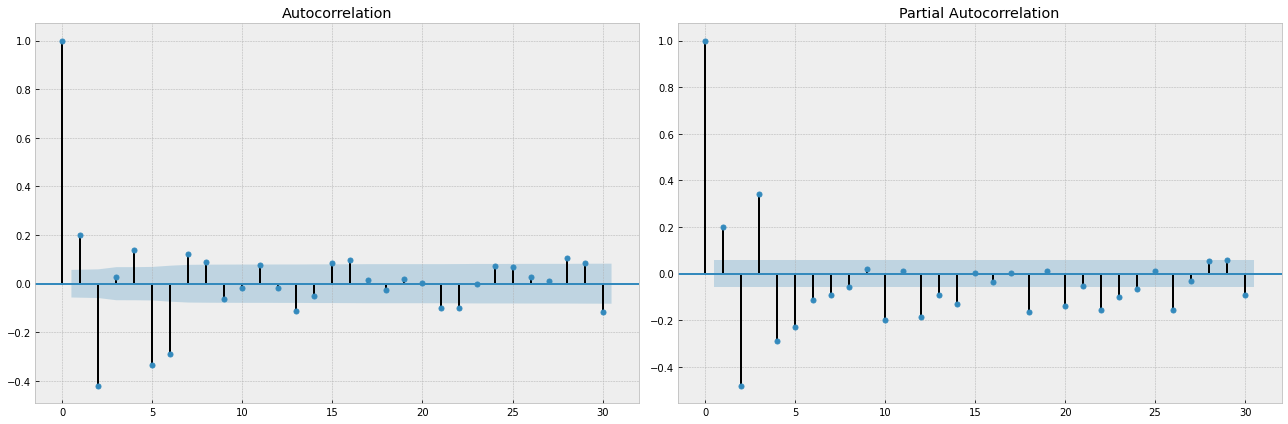

In [67]:
fig, axes = plt.subplots(1, 2)
fig.set_figwidth(18)
fig.set_figheight(6)
smt.graphics.plot_acf(sales_log_diff2, lags=30, ax=axes[0], alpha=0.5)
smt.graphics.plot_pacf(sales_log_diff2, lags=30, ax=axes[1], alpha=0.5,method='ols')
plt.tight_layout()

#### Step 6: Identification of best fit ARIMA model

In [68]:
model = sm.tsa.statespace.SARIMAX(sales_log_diff2, order = (1,0,1), seasonal_order= (1,0,0,12),
                                             enforce_stationarity=False,
                                             enforce_invertibility=False)

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  warnings.warn('No frequency information was'


In [69]:
results = model.fit()
print(results.summary())

                                      SARIMAX Results                                      
Dep. Variable:                        Weekly_Sales   No. Observations:                  141
Model:             SARIMAX(1, 0, 1)x(1, 0, [], 12)   Log Likelihood                 212.406
Date:                             Wed, 22 Feb 2023   AIC                           -416.812
Time:                                     14:58:13   BIC                           -405.404
Sample:                                 02-19-2010   HQIC                          -412.177
                                      - 10-26-2012                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3654      0.063     -5.825      0.000      -0.488      -0.242
ma.L1          1.0000    14

### Iterate the process to find the best values for p, d, q and P, D, Q

In [70]:
# Define the p, d and q parameters to take any value between 0 and 2
p = q = range(0, 2)
d = range(0,2)
# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))

In [71]:
pdq

[(0, 0, 0),
 (0, 0, 1),
 (0, 1, 0),
 (0, 1, 1),
 (1, 0, 0),
 (1, 0, 1),
 (1, 1, 0),
 (1, 1, 1)]

In [72]:
# Generate all different combinations of seasonal p, q and q triplets
D = range(0,2)
P = Q = range(0, 2) 
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(P, D, Q))]
seasonal_pdq

[(0, 0, 0, 12),
 (0, 0, 1, 12),
 (0, 1, 0, 12),
 (0, 1, 1, 12),
 (1, 0, 0, 12),
 (1, 0, 1, 12),
 (1, 1, 0, 12),
 (1, 1, 1, 12)]

In [73]:
import sys
warnings.filterwarnings("ignore") # specify to ignore warning messages

best_aic = np.inf
best_pdq = None
best_seasonal_pdq = None
temp_model = None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        
        try:
            temp_model = sm.tsa.statespace.SARIMAX(sales_log,
                                             order = param,
                                             seasonal_order = param_seasonal,
                                             enforce_stationarity=False,
                                             enforce_invertibility=False)
            results = temp_model.fit()

            # print("SARIMAX{}x{}12 - AIC:{}".format(param, param_seasonal, results.aic))
            if results.aic < best_aic:
                best_aic = results.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal
        except:
            #print("Unexpected error:", sys.exc_info()[0])
            continue
print("Best SARIMAX{}x{}12 model - AIC:{}".format(best_pdq, best_seasonal_pdq, best_aic))

Best SARIMAX(1, 1, 1)x(0, 0, 0, 12)12 model - AIC:-492.97140403611075


#### Step 7: Predict sales on in-sample date using the best fit ARIMA model

The next step is to predict weekly sales for in-sample data and find out how close is the model prediction on the in-sample data to the actual truth.

In [74]:
best_model = sm.tsa.statespace.SARIMAX(sales_log,
                                      order=(1, 1, 1),
                                      seasonal_order=(0, 0, 0, 12),
                                      enforce_stationarity=False,
                                      enforce_invertibility=False)
best_results = best_model.fit()

In [75]:
print(best_results.summary().tables[0])
print(best_results.summary().tables[1])

                               SARIMAX Results                                
Dep. Variable:           Weekly_Sales   No. Observations:                  143
Model:               SARIMAX(1, 1, 1)   Log Likelihood                 249.486
Date:                Wed, 22 Feb 2023   AIC                           -492.971
Time:                        14:58:37   BIC                           -484.146
Sample:                    02-05-2010   HQIC                          -489.385
                         - 10-26-2012                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3754      0.048      7.743      0.000       0.280       0.470
ma.L1         -1.0000     61.122     -0.016      0.987    -120.797     118.797
sigma2         0.0016      0.098      0.016      0.9

In [76]:
sales

Date
2010-02-05    49750740.50
2010-02-12    48336677.63
2010-02-19    48276993.78
2010-02-26    43968571.13
2010-03-05    46871470.30
                 ...     
2012-09-28    43734899.40
2012-10-05    47566639.31
2012-10-12    46128514.25
2012-10-19    45122410.57
2012-10-26    45544116.29
Name: Weekly_Sales, Length: 143, dtype: float64

In [77]:
pred_dynamic = best_results.get_prediction(start=pd.to_datetime('2012-09-14'), full_results=True)

In [78]:
pred_dynamic.predicted_mean

2012-09-14    7.676189
2012-09-21    7.661497
2012-09-28    7.661864
2012-10-05    7.659418
2012-10-12    7.673239
2012-10-19    7.668168
2012-10-26    7.664475
Freq: W-FRI, Name: predicted_mean, dtype: float64

In [79]:
forecast=np.power(10, pred_dynamic.predicted_mean)

In [80]:
actual = sales['2012-09-14':]
actual

Date
2012-09-14    44226038.65
2012-09-21    44354547.11
2012-09-28    43734899.40
2012-10-05    47566639.31
2012-10-12    46128514.25
2012-10-19    45122410.57
2012-10-26    45544116.29
Name: Weekly_Sales, dtype: float64

In [81]:
#Mean absolute percentage error
MAPE_last1year = np.mean(np.abs(actual - forecast)/actual)

In [82]:
print('The Mean Absolute percentage error of our forecast for last two years is {}'.format(round(MAPE_last1year, 4)))

The Mean Absolute percentage error of our forecast for last two years is 0.0378


In [83]:
# Compute the mean square error
mse = ((actual - forecast) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 4)))
print('The ROOT Mean Squared Error of our forecasts is {}'.format(np.sqrt(round(mse, 4))))

The Mean Squared Error of our forecasts is 3507664065637.4653
The ROOT Mean Squared Error of our forecasts is 1872875.8810015856


In [84]:
np.power(10, best_results.forecast(steps=12))

2012-11-02    4.633923e+07
2012-11-09    4.664129e+07
2012-11-16    4.675519e+07
2012-11-23    4.679802e+07
2012-11-30    4.681411e+07
2012-12-07    4.682015e+07
2012-12-14    4.682242e+07
2012-12-21    4.682327e+07
2012-12-28    4.682359e+07
2013-01-04    4.682371e+07
2013-01-11    4.682375e+07
2013-01-18    4.682377e+07
Freq: W-FRI, Name: predicted_mean, dtype: float64

#### Step 8: Forecast sales using the best fit ARIMA model

The next step is to predict weekly sales for next 3 years i.e. for 2013, 2014, and 2015 through the above model.

In [85]:
# Get forecast 36 steps (3 years) ahead in future
n_steps = 36
pred_uc_99 = best_results.get_forecast(steps=36, alpha=0.01) # alpha=0.01 signifies 99% confidence interval
pred_uc_95 = best_results.get_forecast(steps=36, alpha=0.05) # alpha=0.05 95% CI

# Get confidence intervals 95% & 99% of the forecasts
pred_ci_99 = pred_uc_99.conf_int()
pred_ci_95 = pred_uc_95.conf_int()

In [86]:
pred_ci_99.head()

,lower Weekly_Sales,upper Weekly_Sales
2012-11-02,7.587072,7.744825
2012-11-09,7.584325,7.753216
2012-11-16,7.584557,7.755102
2012-11-23,7.584812,7.755643
2012-11-30,7.584931,7.755822


In [87]:
pred_ci_95.head()

,lower Weekly_Sales,upper Weekly_Sales
2012-11-02,7.587072,7.744825
2012-11-09,7.584325,7.753216
2012-11-16,7.584557,7.755102
2012-11-23,7.584812,7.755643
2012-11-30,7.584931,7.755822


In [88]:
n_steps = 36
idx = pd.date_range(sales.index[-1], periods=n_steps, freq='MS')
fc_95 = pd.DataFrame(np.column_stack([np.power(10, pred_uc_95.predicted_mean), np.power(10, pred_ci_95)]), 
                     index=idx, columns=['forecast', 'lower_ci_95', 'upper_ci_95'])
fc_99 = pd.DataFrame(np.column_stack([np.power(10, pred_ci_99)]), 
                     index=idx, columns=['lower_ci_99', 'upper_ci_99'])

In [89]:
fc_95.head()

,forecast,lower_ci_95,upper_ci_95
2012-11-01,4.633923e+07,3.864312e+07,5.556808e+07
2012-12-01,4.664129e+07,3.839949e+07,5.665204e+07
2013-01-01,4.675519e+07,3.842000e+07,5.689869e+07
2013-02-01,4.679802e+07,3.844254e+07,5.696956e+07
2013-03-01,4.681411e+07,3.845308e+07,5.699311e+07


In [90]:
fc_99.head()

,lower_ci_99,upper_ci_99
2012-11-01,3.864312e+07,5.556808e+07
2012-12-01,3.839949e+07,5.665204e+07
2013-01-01,3.842000e+07,5.689869e+07
2013-02-01,3.844254e+07,5.696956e+07
2013-03-01,3.845308e+07,5.699311e+07


In [91]:
fc_all = fc_95.combine_first(fc_99)
fc_all = fc_all[['forecast', 'lower_ci_95', 'upper_ci_95', 'lower_ci_99', 'upper_ci_99']] # just reordering columns
fc_all.head()

,forecast,lower_ci_95,upper_ci_95,lower_ci_99,upper_ci_99
2012-11-01,4.633923e+07,3.864312e+07,5.556808e+07,3.864312e+07,5.556808e+07
2012-12-01,4.664129e+07,3.839949e+07,5.665204e+07,3.839949e+07,5.665204e+07
2013-01-01,4.675519e+07,3.842000e+07,5.689869e+07,3.842000e+07,5.689869e+07
2013-02-01,4.679802e+07,3.844254e+07,5.696956e+07,3.844254e+07,5.696956e+07
2013-03-01,4.681411e+07,3.845308e+07,5.699311e+07,3.845308e+07,5.699311e+07


In [92]:
pd.plotting.register_matplotlib_converters()

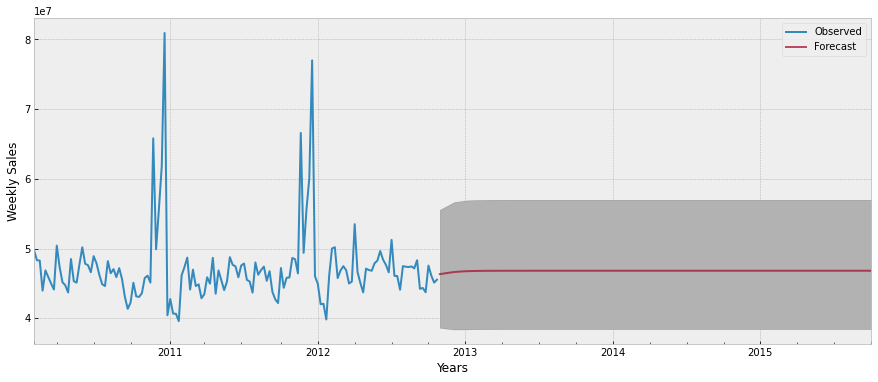

In [93]:
# plot the forecast along with the confidence band
axis = sales.plot(label='Observed', figsize=(15, 6))
fc_all['forecast'].plot(ax=axis, label='Forecast', alpha=0.7)
#axis.fill_between(fc_all.index, fc_all['lower_ci_95'], fc_all['upper_ci_95'], color='k', alpha=.25)
axis.fill_between(fc_all.index, fc_all['lower_ci_99'], fc_all['upper_ci_99'], color='k', alpha=.25)
axis.set_xlabel('Years')
axis.set_ylabel('Weekly Sales')
plt.legend(loc='best')
plt.show()

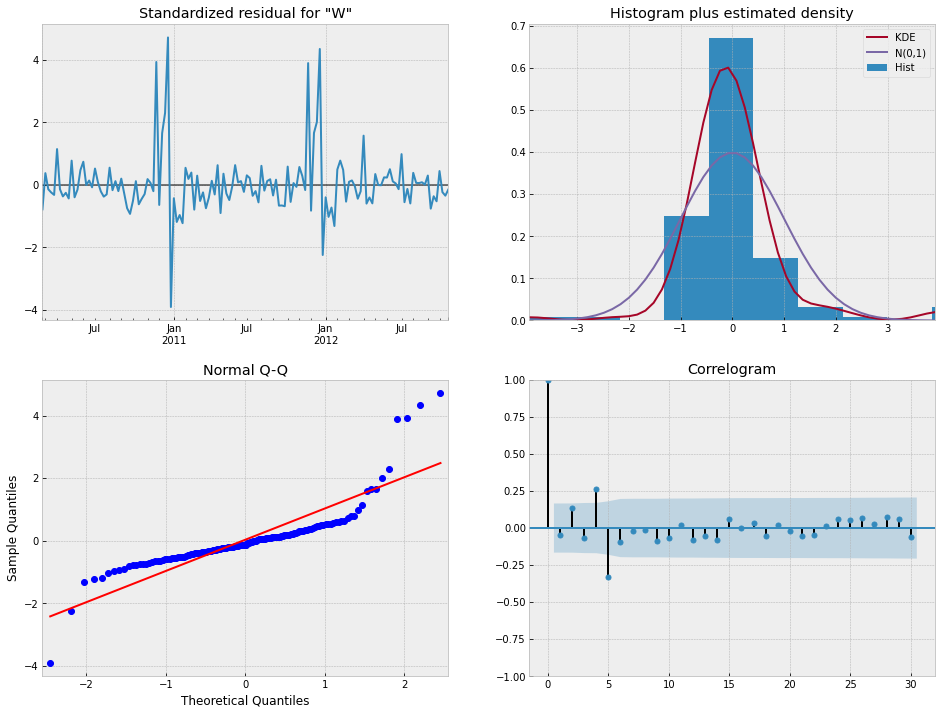

In [94]:
best_results.plot_diagnostics(lags=30, figsize=(16,12))
plt.show()

## Single Exponential Smoothing

In [95]:
### single exponential smoothing/ ETS
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# our guessed parameters
alpha = 0.4
beta = 0.2
gamma = 0.01

# initialise model
ets_model = ExponentialSmoothing(sales, trend='add', seasonal='add', seasonal_periods=12)
#ets_fit = ets_model.fit(smoothing_level=alpha, smoothing_slope=beta, smoothing_seasonal=gamma)
ets_fit = ets_model.fit(optimized=True)

In [96]:
# forecast p months ahead
p_ahead = 36
yh = ets_fit.forecast(p_ahead)

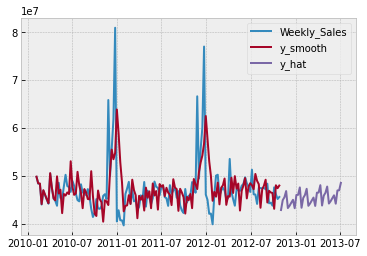

In [97]:
# plot the y, y_smoothed and y_hat ts'
plt.plot(sales, label='Weekly_Sales')
plt.plot(ets_fit.fittedvalues, label='y_smooth')
plt.plot(yh, label='y_hat')

plt.legend()
plt.show()